# Applied Seismology, GEOS 626, University of Alaska Fairbanks

- script lab_response.ipynb

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import warnings

from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime

In [2]:
# script settings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 5

In [3]:
# getting the inventory

client = Client("IRIS")

starttime = UTCDateTime(2004, 12, 26, 0, 58, 50)
endtime   = starttime + ( 5 * 24 * 60 * 60 )        # 5 days after the start time

# check the page - https://docs.obspy.org/packages/obspy.core.inventory.html, 
# for detailed information on the inventory object

waveforms = ['G.CAN.'    ,
             'II.ALE.00' ,
             'IU.ANMO.00']

# choose a waveform based on the network whose response you want to look at
picked_waveform = waveforms[0]

net, sta, loc = picked_waveform.split('.')

inv_LHZ = client.get_stations(network=net, station=sta, location=loc, channel="LHZ", starttime=starttime,
                              endtime=endtime, level="response")
inv_BHZ = client.get_stations(network=net, station=sta, location=loc, channel="BHZ", starttime=starttime,
                              endtime=endtime, level="response")

In [4]:
# see details about the instrument response

# set inventory for the channel of interest
#inv = inv_LHZ.copy()
inv = inv_BHZ.copy()

print(inv)

Inventory created at 2026-01-02T22:41:14.566000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2004-12-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			G
		Stations (1):
			G.CAN (Canberra, Australia)
		Channels (1):
			G.CAN..BHZ


In [5]:
print(inv[0])

Network G (GEOSCOPE - French Global Network of Seismological Broadband Stations (GEOSCOPE))
	Station Count: 1/57 (Selected/Total)
	1982-01-01T00:00:00.000000Z - --
	Access: open
	Alternate Code: GEOSCOPE
	Contains:
		Stations (1):
			G.CAN (Canberra, Australia)
		Channels (1):
			G.CAN..BHZ


In [6]:
print(inv[0][0])

Station CAN (Canberra, Australia)
	Station Code: CAN
	Channel Count: 1/35 (Selected/Total)
	1987-11-27T00:00:00.000000Z - 
	Access: open 
	Latitude: -35.3187, Longitude: 148.9963, Elevation: 700.0 m
	Available Channels:
	    ..BHZ        20.0 Hz  1987-11-27 to 2006-12-10



In [7]:
print(inv[0][0][0])

Channel 'BHZ', Location '' 
	Time range: 1987-11-27T00:00:00.000000Z - 2006-12-10T02:00:00.000000Z
	Latitude: -35.3187, Longitude: 148.9963, Elevation: 700.0 m, Local Depth: 0.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: -90.00 degrees down from horizontal
	Channel types: CONTINUOUS, GEOPHYSICAL
	Sampling Rate: 20.00 Hz
	Sensor (Description): None (STRECKEISEN STS1)
	Response information available


In [8]:
# collect key values from the inventory

samples_per_second = inv[0][0][0].sample_rate
dt = 1/samples_per_second
Nyquist_frequency  = 1 / (2*dt)
print(f'sample rate = {samples_per_second} 1/s, dt = {dt} s, Nyquist frequency = {Nyquist_frequency} Hz \n')

print(inv[0][0][0].response)

sample rate = 20.0 1/s, dt = 0.05 s, Nyquist frequency = 10.0 Hz 

Channel Response
	From m/s (VELOCITY in Meters Per Second) to counts (DIGITAL UNIT in Counts)
	Overall Sensitivity: 2.30605e+08 defined at 0.010 Hz
	3 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 2252
		Stage 2: PolesZerosResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to counts, gain: 102400


In [9]:
# check the page - https://docs.obspy.org/packages/autogen/obspy.core.inventory.inventory.Inventory.plot_response.html,
# for detailed information on plotting response using this method

#inv.plot_response?

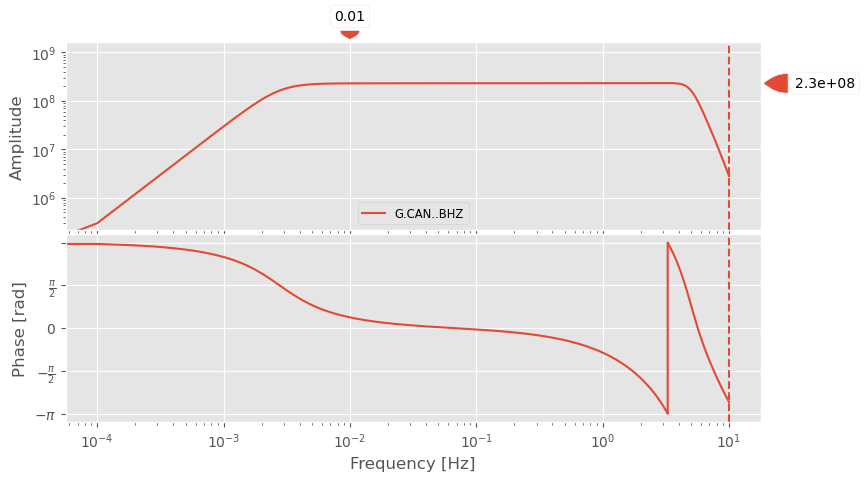

In [10]:
#inv = inv_LHZ.copy()

# plot the instrument response (note: semi-colon is needed to block a repeated plot)
inv.plot_response(min_freq=0.0001);

In [11]:
# optional: plot the stages separately
#inv[0][0][0].plot(min_freq=0.0001, start_stage=1, end_stage=1, output="VEL");
#inv[0][0][0].plot(min_freq=0.0001, start_stage=2, end_stage=2, output="VEL");
#inv[0][0][0].plot(min_freq=0.0001, start_stage=3, end_stage=3, output="VEL");

In [12]:
# from here on out, we will specify the specific frequencies for which we will evaluate the instrument response
f = np.logspace(-4.0, 2.0, num=100)

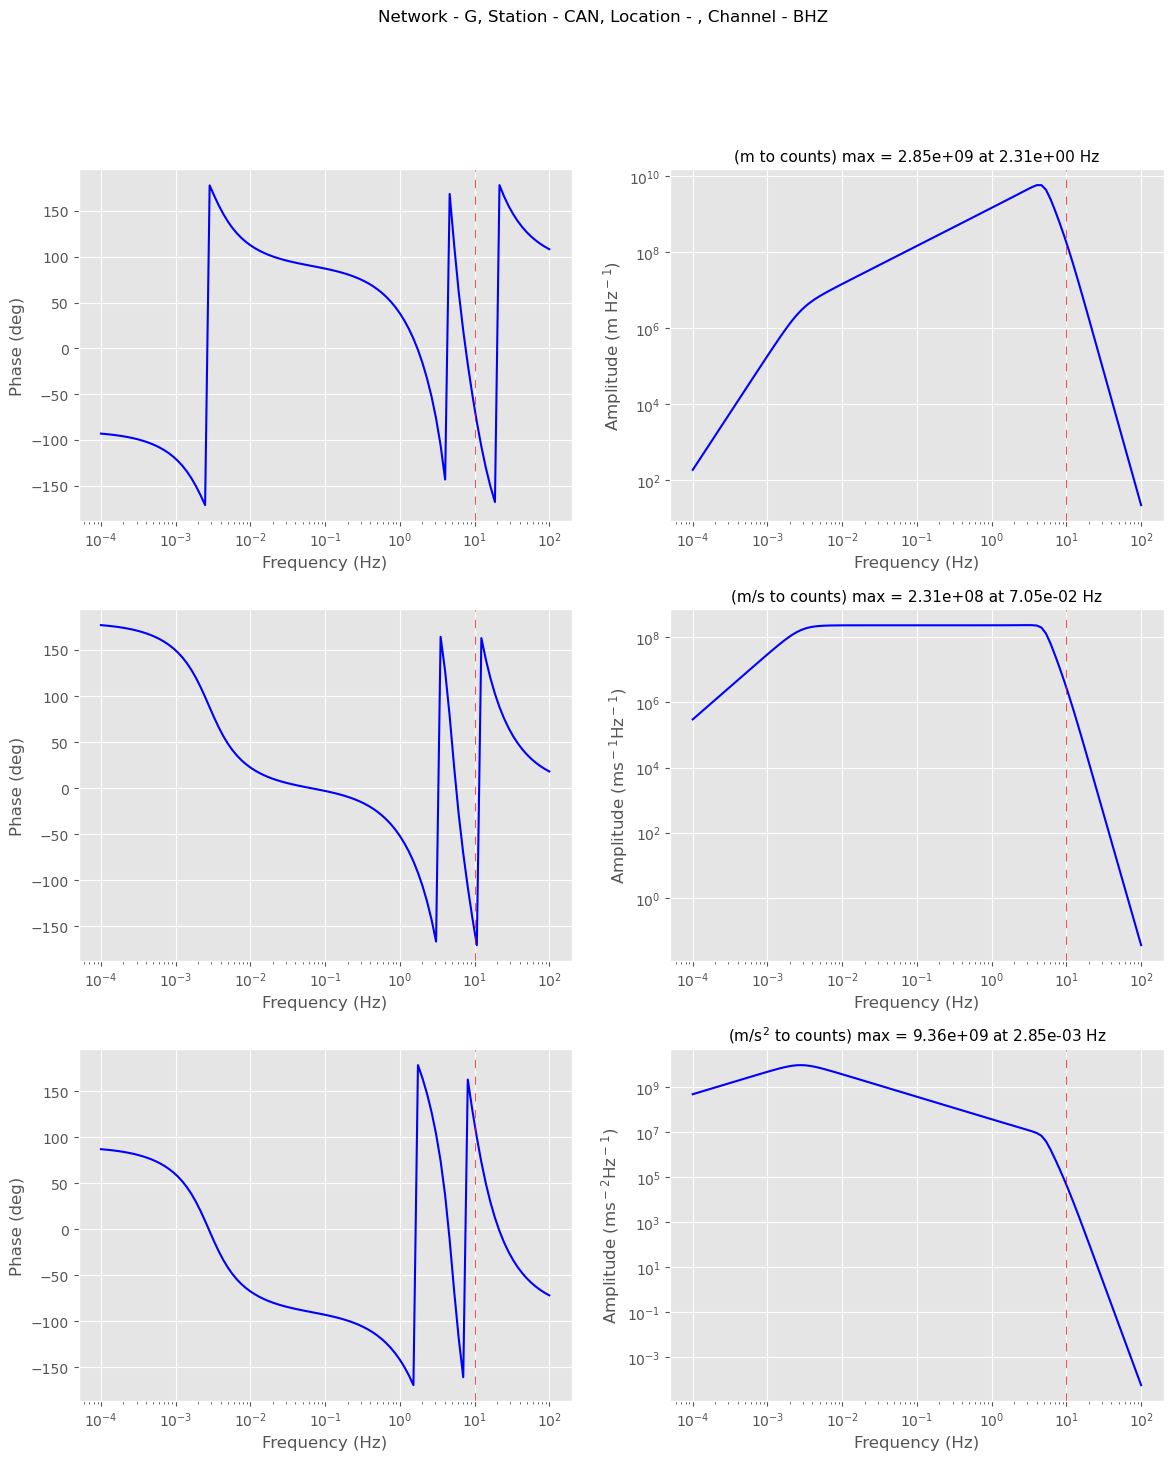

In [13]:
# retrieving the combined instrument response for all stages

start_stage = None
end_stage = None

Id = inv[0][0][0].response.get_evalresp_response_for_frequencies(f, output='DISP', start_stage= start_stage,
                                                                 end_stage=end_stage)
Iv = inv[0][0][0].response.get_evalresp_response_for_frequencies(f, output='VEL', start_stage= start_stage,
                                                                 end_stage=end_stage)
Ia = inv[0][0][0].response.get_evalresp_response_for_frequencies(f, output='ACC', start_stage= start_stage,
                                                                 end_stage=end_stage)

max_Id   = max(Id)
f_Id_max = f[np.nonzero(Id == max_Id)]
max_Iv   = max(Iv)
f_Iv_max = f[np.nonzero(Iv == max_Iv)]
max_Ia   = max(Ia)
f_Ia_max = f[np.nonzero(Ia == max_Ia)]

fig, ax = plt.subplots(3, 2, figsize=(14,16))

ax[0,0].semilogx(f, np.angle(Id)*180/np.pi, color='b')
ax[0,0].set(xlabel='Frequency (Hz)', ylabel='Phase (deg)')
ax[0,0].axvline(Nyquist_frequency, c='r', lw=0.5, ls='--', dashes=[12,12])

ax[0,1].loglog(f, abs(Id), color='b')
ax[0,1].set(xlabel='Frequency (Hz)', ylabel='Amplitude (m Hz$^-$$^1$)')
ax[0,1].axvline(Nyquist_frequency, c='r', lw=0.5, ls='--', dashes=[12,12])
ax[0,1].set_title('(m to counts) max = %.2e at %.2e Hz'% (np.real(max_Id), f_Id_max[0]), fontsize=11)

ax[1,0].semilogx(f, np.angle(Iv)*180/np.pi, color='b')
ax[1,0].set(xlabel='Frequency (Hz)', ylabel='Phase (deg)')
ax[1,0].axvline(Nyquist_frequency, c='r', lw=0.5, ls='--', dashes=[12,12])

ax[1,1].loglog(f, abs(Iv), color='b')
ax[1,1].set(xlabel='Frequency (Hz)', ylabel='Amplitude (ms$^-$$^1$Hz$^-$$^1$)')
ax[1,1].axvline(Nyquist_frequency, c='r', lw=0.5, ls='--', dashes=[12,12])
ax[1,1].set_title('(m/s to counts) max = %.2e at %.2e Hz'% (np.real(max_Iv), f_Iv_max[0]), fontsize=11)

ax[2,0].semilogx(f, np.angle(Ia)*180/np.pi, color='b')
ax[2,0].set(xlabel='Frequency (Hz)', ylabel='Phase (deg)')
ax[2,0].axvline(Nyquist_frequency, c='r', lw=0.5, ls='--', dashes=[12,12])

ax[2,1].loglog(f, abs(Ia), color='b')
ax[2,1].set(xlabel='Frequency (Hz)', ylabel='Amplitude (ms$^-$$^2$Hz$^-$$^1$)')
ax[2,1].set_title('(m/s$^2$ to counts) max = %.2e at %.2e Hz'% (np.real(max_Ia), f_Ia_max[0]), fontsize=11)
ax[2,1].axvline(Nyquist_frequency, c='r', lw=0.5, ls='--', dashes=[12,12])

fig.suptitle(f'Network - {inv[0].code}, Station - {inv[0][0].code}, Location - {inv[0][0][0].location_code}, Channel - {inv[0][0][0].code}', fontsize=12)

plt.subplots_adjust(hspace=0.25)

Text(0.5, 0.98, 'Network - G, Station - CAN, Location - ')

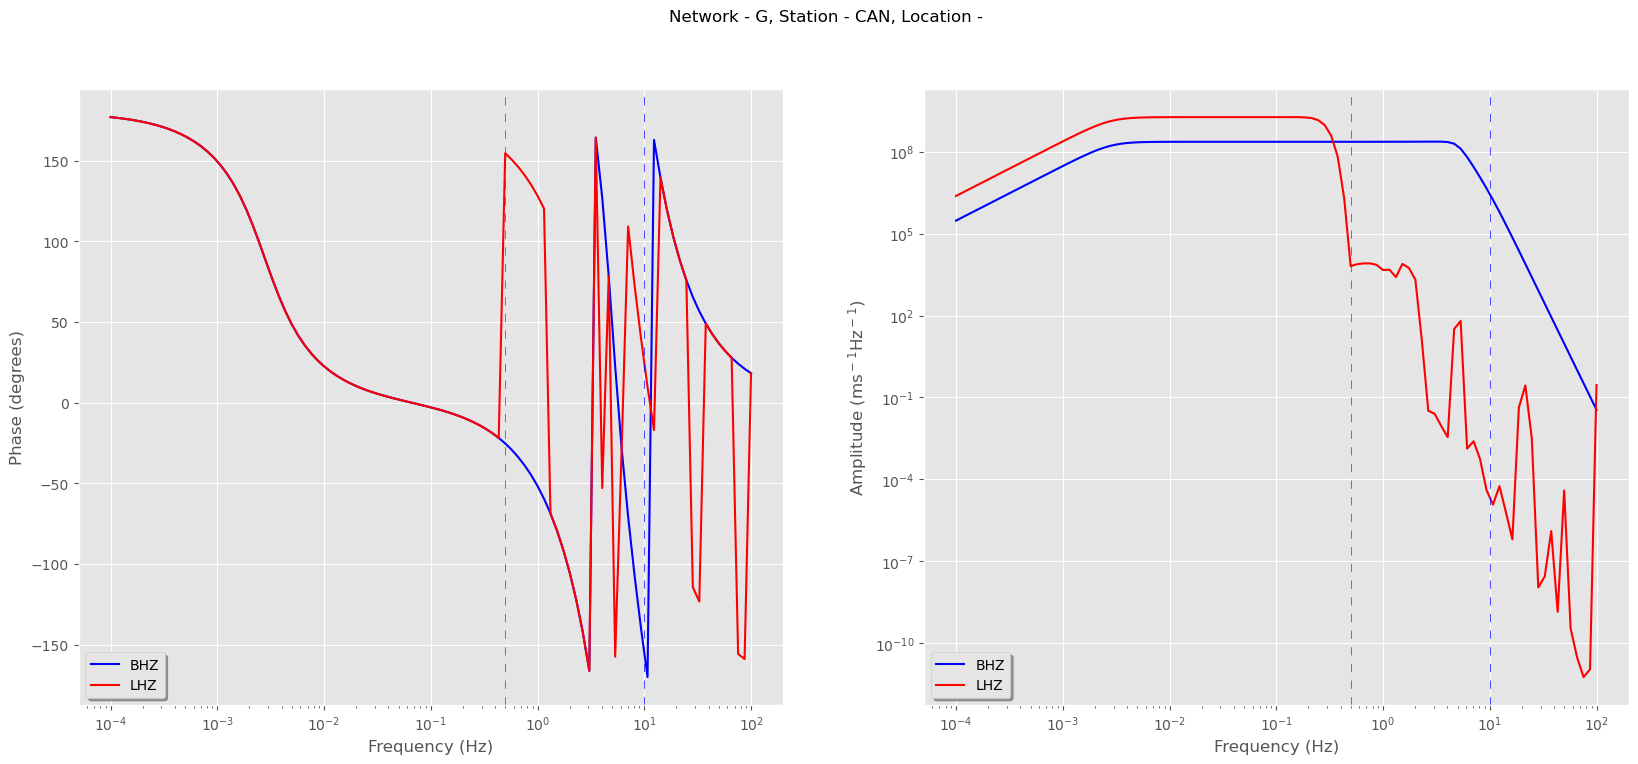

In [14]:
# superimposing BHZ and LHZ instrument responses for velocity
# NOTE - the plots below represent the combined instrument response for all stages

Iv_BHZ = inv_BHZ[0][0][0].response.get_evalresp_response_for_frequencies(f, output='VEL')
Iv_LHZ = inv_LHZ[0][0][0].response.get_evalresp_response_for_frequencies(f, output='VEL')

fNy_BHZ = (inv_BHZ[0][0][0].sample_rate) / 2
fNy_LHZ = (inv_LHZ[0][0][0].sample_rate) / 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.semilogx(f, np.angle(Iv_BHZ)*180/np.pi, color='b', label='BHZ')
ax1.semilogx(f, np.angle(Iv_LHZ)*180/np.pi, color='r', label='LHZ')
ax1.axvline(fNy_BHZ, c='b', lw=0.5, ls='--', dashes=[12,12])
ax1.axvline(fNy_LHZ, c='r', lw=0.5, ls='--', dashes=[12,12])
ax1.set(xlabel='Frequency (Hz)', ylabel='Phase (degrees)')
ax1.legend(loc='lower left', shadow=True)

ax2.loglog(f, abs(Iv_BHZ), color='b', label='BHZ')
ax2.loglog(f, abs(Iv_LHZ), color='r', label='LHZ')
ax2.axvline(fNy_BHZ, c='b', lw=0.5, ls='--', dashes=[12,12])
ax2.axvline(fNy_LHZ, c='r', lw=0.5, ls='--', dashes=[12,12])
ax2.set(xlabel='Frequency (Hz)', ylabel='Amplitude (ms$^-$$^1$Hz$^-$$^1$)')
ax2.legend(loc='lower left', shadow=True)

fig.suptitle(f'Network - {inv[0].code}, Station - {inv[0][0].code}, Location - {inv[0][0][0].location_code}', fontsize=12)